## Packages

In [9]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import lightgbm                 as lgb
import xgboost                  as xgb
import shap

from imblearn.under_sampling    import RandomUnderSampler
from imblearn.over_sampling     import RandomOverSampler

from sklearn.model_selection    import RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose            import ColumnTransformer
from sklearn.metrics            import classification_report, precision_recall_curve, recall_score, precision_score, f1_score, auc, roc_curve, plot_confusion_matrix


from sklearn.decomposition      import TruncatedSVD
from sklearn.calibration        import CalibratedClassifierCV
from sklearn.feature_selection  import RFECV
from scipy.stats                import ks_2samp

from sklearn.svm                import SVC, LinearSVC
from sklearn.neighbors          import KNeighborsClassifier, NearestCentroid
from sklearn.tree               import DecisionTreeClassifier
from sklearn.linear_model       import RidgeClassifier, RidgeClassifierCV, SGDClassifier, LogisticRegressionCV, PassiveAggressiveClassifier, LogisticRegression, Perceptron
from sklearn.gaussian_process   import GaussianProcessClassifier
from sklearn.ensemble           import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes        import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

## Plotting style and colors

In [10]:
plt.style.reload_library()
plt.rcParams['font.size'] = 18 
plt.style.use(['science', 'notebook', 'grid'])

blue = '#1f77b4'
golden = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
light_blue = '#17becf'

## EDA

In [11]:
df = pd.read_csv("/home/saim/Desktop/abor", sep='\t')
df.head()

Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.


,BatchGroup,Server,Customer,PrimaryModule,AttachmentUri,Version,ServiceType,SecondaryModule,OSVersion,BatchJob,...,RunningCitrix,InstallationType,Subject,BuildId,PatchLevel,SecondaryFunction,XmlUri,ErrorNumber,Track,is_defect
0,NaN,NaN,GJEN,NaN,NaN,21.04,NaN,NaN,Microsoft Windows NT 6.3.9600.0,NaN,...,Yes,Production,Invalid global rule assignment(s) - Show Expir...,21.04-SP0-IMPL-20210824-1,NaN,NaN,https://errorlogsprod.blob.core.windows.net/xm...,36518.0,IMPL,False
1,NaN,BATCH01,CNP,0.0,NaN,22.01,NaN,0.0,Windows 10 10.0.14393,NaN,...,No,Non-Production,Database error (SELECT BATCHQUEUE.BATCHQUEUEIK...,22.01-SP0-IMPL-20220119-1,NaN,dbContResolve,https://errorlogsprod.blob.core.windows.net/xm...,0.0,IMPL,False
2,NaN,NaN,SWIB,4764.0,NaN,21.04,NaN,147.0,Windows 10 10.0.14393,NaN,...,Yes,Non-Production,Database error (INSERT INTO CACHOICES(BALNOMVA...,21.04-SP0-IMPL-20210702-1,NaN,dbContResolve,https://errorlogsprod.blob.core.windows.net/xm...,1506.0,IMPL,True
3,NaN,NaN,NORD,NaN,NaN,21.04,NaN,NaN,Microsoft Windows NT 10.0.14393.0,NaN,...,Yes,Production,Invalid global rule assignment(s) - Show Expir...,21.04-SP0-IMPL-20220106-1,NaN,NaN,https://errorlogsprod.blob.core.windows.net/xm...,477559.0,IMPL,False
4,NaN,NaN,TDK2,NaN,NaN,22.04,Compliance post-trade service,NaN,Microsoft Windows NT 6.2.9200.0,NaN,...,No,Internal,External component has thrown an exception.,22.04-SP0-IMPL-20220415-1,"180,(185-187),(191-192),(211-212),214,(216-226)",NaN,https://errorlogsprod.blob.core.windows.net/xm...,286488.0,IMPL,False


In [4]:
print(df.shape)

(64824, 48)


In [6]:
def Overview(df, sort_by_missing=True):
    # Preliminary data overview
    uniques = df.nunique()
    dtypes = df.dtypes
    total = df.isnull().sum().sort_values()
    percent = (df.isnull().sum() / df.isnull().count()).sort_values() * 100

    if len(df.dropna()) > 0:
        sample = df.dropna().iloc[0].astype(str).apply(lambda x: x[:30])
    else:
        sample = df.iloc[0].astype(str).apply(lambda x: x[:30])

    data_overview = [sample, uniques, dtypes, total, percent]
    keys = ["Sample", "Count uniques", "dtype", "Count missing", "Pct. missing"]

    overview_df = pd.concat(data_overview, keys=keys, axis=1, sort=False)
    if sort_by_missing:
        overview_df = overview_df.sort_values(by="Pct. missing", ascending=False)
    overview_df = overview_df.round(1)
    return overview_df

overview = Overview(df)
overview

,Sample,Count uniques,dtype,Count missing,Pct. missing
ServiceType,nan,104,object,60282,93.0
BatchJob,nan,4785,object,57716,89.0
BatchGroup,nan,2828,object,57461,88.6
PatchLevel,nan,955,object,53330,82.3
AttachmentUri,nan,11991,object,52833,81.5
StacktraceClass,nan,1748,object,52501,81.0
StacktraceNamespace,nan,764,object,52501,81.0
StacktraceMethod,nan,2620,object,52501,81.0
StacktraceLine,nan,2272,object,52501,81.0
Server,nan,9658,object,43799,67.6


In [19]:
# Looking at value counts of target feature and the ratio of it
class_array = np.array(df['is_defect'].value_counts())
print(class_array)

[60777  4047]


In [21]:
print('Imbalance Ratio', round(class_array[1]/class_array[0], 3))

Imbalance Ratio 0.067


In [22]:
class_array[0]

60777

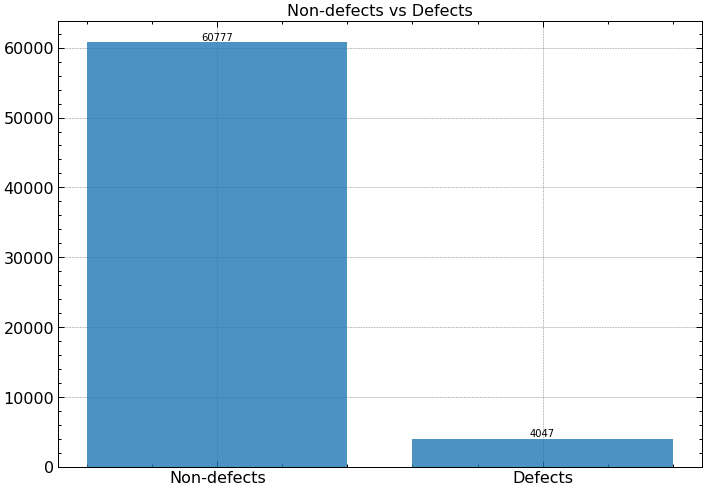

In [23]:
# Plotting the classes
objects = ('Non-defects', 'Defects')
y_pos = np.arange(len(objects))
performance = np.array([class_array[0], class_array[1],])


fig, ax = plt.subplots(figsize=(10, 7))


plt.bar(y_pos, performance, align='center', alpha= 0.8, color = blue)
plt.xticks(y_pos, objects)

ax.bar_label(ax.containers[0])


plt.title('Non-defects vs Defects')
plt.savefig("/home/saim/Desktop/class_imb.png")

fig.tight_layout()

In [7]:
num_variables = df.select_dtypes(include='number').columns.tolist()
print(num_variables, len(num_variables), 'numerical variables')

cat_variables = df.select_dtypes(exclude='number').columns.tolist()
print(cat_variables, len(cat_variables), 'non-numeric variables')

['PrimaryModule', 'SecondaryModule', 'WorkspaceSize', 'ApplicationId', 'ProcessorCount', 'ErrorNumber'] 6 numerical variables
['BatchGroup', 'Server', 'Customer', 'AttachmentUri', 'Version', 'ServiceType', 'OSVersion', 'BatchJob', 'SubMessageType', 'StackTrace', 'StacktraceMethod', 'SessionStartTime', 'State', 'RootCause', 'UTCImported', 'ServicePack', 'ModuleList', 'UTCLogDate', 'StacktraceLine', 'PrimaryFunction', 'Ora', 'StacktraceNamespace', 'User', 'CDataSection', 'StacktraceClass', 'ResponsibleTeam', 'OSUser', 'Source', 'Machine', 'ProcessType', 'MenuId', 'ProgrammersMode', 'RCReference', 'RunningCitrix', 'InstallationType', 'Subject', 'BuildId', 'PatchLevel', 'SecondaryFunction', 'XmlUri', 'Track', 'is_defect'] 42 non-numeric variables


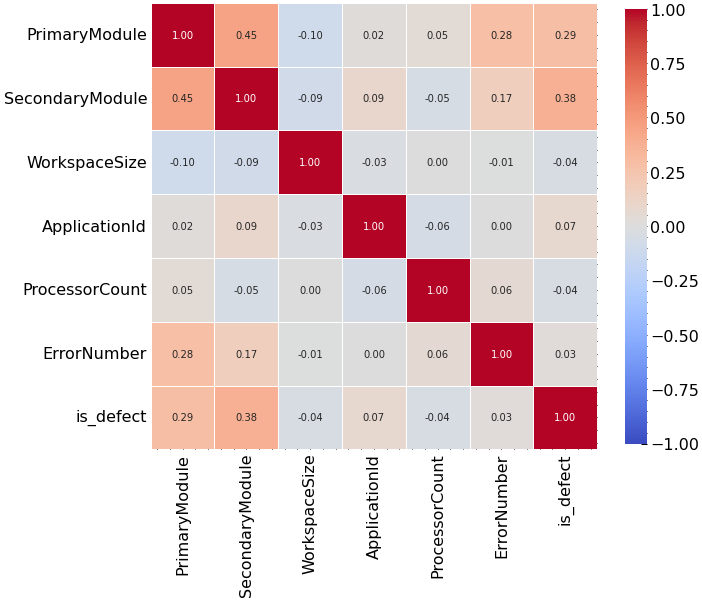

In [11]:
def heatmap(dataframe, h=10, w=10, cmap="coolwarm", vmin=-1.0, vmax=1.0):
    fig, ax = plt.subplots(figsize=(h, w))
    sns.heatmap(
        dataframe.corr(),
        vmin=-1.0,
        vmax=1.0,
        center=0,
        fmt=".2f",
        cmap=cmap,
        square=True,
        linewidths=0.5,
        annot=True,
        cbar_kws={"shrink": 0.80},
    )
    plt.savefig("/home/saim/Desktop/corr_heat.png")
    plt.show()

heatmap(df)

In [13]:
df.describe

<bound method NDFrame.describe of       BatchGroup               Server Customer  PrimaryModule AttachmentUri  \
0            NaN                  NaN     GJEN            NaN           NaN   
1            NaN              BATCH01      CNP            0.0           NaN   
2            NaN                  NaN     SWIB         4764.0           NaN   
3            NaN                  NaN     NORD            NaN           NaN   
4            NaN                  NaN     TDK2            NaN           NaN   
...          ...                  ...      ...            ...           ...   
64819        NaN                  NaN      LUP            0.0           NaN   
64820        NaN  UNGD01APP120\214-15     UNIG            0.0           NaN   
64821        NaN                  NaN     STOR            NaN           NaN   
64822        NaN                  NaN    BCIMC            NaN           NaN   
64823        NaN                  NaN     POHJ            NaN           NaN   

      Version    

In [8]:
df_ks_test = df.copy()

df_ks_test['PrimaryModule'].fillna(df_ks_test['PrimaryModule'].mean(), inplace = True)
print(df_ks_test['PrimaryModule'].isnull().values.any())


def df_to_np(df, col_name):
    return np.array(df[col_name])

# convert cols to np arrays to be used in ks-test
PrimaryModule_array = df_to_np(df_ks_test, 'PrimaryModule')
PrimaryModule_OG = df_to_np(df, 'PrimaryModule')

print(ks_2samp(PrimaryModule_array, PrimaryModule_OG))

False
KstestResult(statistic=0.38633839318770835, pvalue=0.0)


In [28]:
def histogram(dataframe, col_name:str):

       fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(31, 10))

       # Plot generated data
       ax.hist(dataframe[col_name], 
              bins = 1000, 
              color = blue,
              histtype = 'step', 
              )

       ax.set(xlabel = "Value", 
              ylabel = "Frequency", 
              #title = ""
       )


       ax.set(xlabel = "Value", ylabel = "Frequency", title = "")
       ax.legend(loc = 'upper left', fontsize = 16);


       #plt.savefig("/home/saim/Desktop/name.png")
       fig.tight_layout()

#histogram(df, 'ProcessorCount')

## Data Cleaning

In [5]:
df_1 = df.copy()


"""
Returns list of column names above x percent missing values which can then be removed
"""
def get_NA_cols(dataframe):

    percent = (dataframe.isnull().sum() / dataframe.isnull().count()).sort_values() * 100
    percent = percent[percent > 30]

    ls = list(percent.index)
    ls.remove('RootCause')
    return ls

columns = get_NA_cols(df_1)
print(columns) 

df_1.drop(columns, axis = 1, inplace = True)
                
print(df.shape)
print(df_1.shape)

['MenuId', 'ProcessorCount', 'PrimaryModule', 'ApplicationId', 'SecondaryModule', 'PrimaryFunction', 'SecondaryFunction', 'ProcessType', 'SubMessageType', 'StackTrace', 'Ora', 'Server', 'StacktraceMethod', 'StacktraceLine', 'StacktraceClass', 'StacktraceNamespace', 'AttachmentUri', 'PatchLevel', 'BatchGroup', 'BatchJob', 'ServiceType']
(64824, 48)
(64824, 27)


In [315]:
X = df_1.iloc[:, :-1]
y = df_1.iloc[:, -1:]


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df_1["is_defect"],
                                                   )

y_train_tr = y_train.to_numpy().ravel()
y_test_tr = y_test.to_numpy().ravel()

In [316]:
def split_num_cat(train_x):
    
    # Get list of numerical variables
    num_variables = train_x.select_dtypes(include='number').columns.tolist()
    print(num_variables, len(num_variables), 'numerical variables')
    
    # Get list of categorical variables
    cat_variables = train_x.select_dtypes(exclude='number').columns.tolist()
    print(cat_variables, len(cat_variables), 'categorical variables')

    return num_variables, cat_variables

numeric_variables, categorical_variables = split_num_cat(X_train)

['WorkspaceSize', 'ErrorNumber'] 2 numerical variables
['Customer', 'Version', 'OSVersion', 'SessionStartTime', 'State', 'RootCause', 'UTCImported', 'ServicePack', 'ModuleList', 'UTCLogDate', 'User', 'CDataSection', 'ResponsibleTeam', 'OSUser', 'Source', 'Machine', 'ProgrammersMode', 'RCReference', 'RunningCitrix', 'InstallationType', 'Subject', 'BuildId', 'XmlUri', 'Track'] 24 categorical variables


In [317]:
num_pipeline_ord = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0.0)), ("scaler", StandardScaler())
          ]
)


cat_pipeline_ord = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value="none")), 
           ('labelencoder', OneHotEncoder(handle_unknown='ignore')),
          ]
)


preprocessor_ord = ColumnTransformer(transformers=[
    ('number', num_pipeline_ord, numeric_variables),
    ('category', cat_pipeline_ord, categorical_variables)
])


X_train_trans_ord = preprocessor_ord.fit_transform(X_train)
X_train_trans_ord.shape

(51859, 362538)

NameError: name 'fig' is not defined

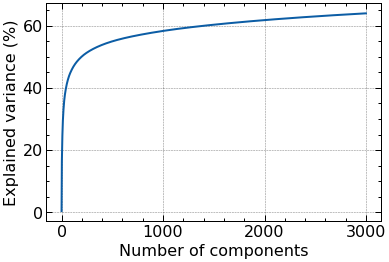

In [8]:
svd = TruncatedSVD(n_components=3000, n_iter=7, random_state=69)
svd.fit(X_train_trans_ord)


plt.plot(np.cumsum(svd.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

plt.savefig("/home/saim/Desktop/svd.png")

fig.tight_layout()

In [318]:
num_pipeline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())
          ]
)


cat_pipeline = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='constant', fill_value="none")), 
           ('labelencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
          ]
)


preprocessor = ColumnTransformer(transformers=[
    ('number', num_pipeline, numeric_variables),
    ('category', cat_pipeline, categorical_variables)
])

In [9]:
# array to df for pycaret
#train_df = pd.DataFrame(X_train_trans, index=X_train.index, columns=X_train.columns)

## Model Fitting

In [15]:
models = {'LogisticRegression' : LogisticRegression(random_state=42),
'Random_Forest' : RandomForestClassifier(),
'KNN' : KNeighborsClassifier(),
'SVM' : SVC(random_state=42),
'Naive_Bayes' : GaussianNB(),
'XGB' : xgb.XGBClassifier(random_state=42),
'LGBM' : lgb.LGBMClassifier(random_state=42),
'Decision_Tree' : DecisionTreeClassifier(random_state=42),
'SGDClassifier' : SGDClassifier(random_state=42),
'RidgeClassifierCV' : RidgeClassifierCV(),
'RidgeClassifier' : RidgeClassifier(),
'PassiveAggressiveClassifier' : PassiveAggressiveClassifier(random_state=42),
'GaussianProcessClassifier' : GaussianProcessClassifier(random_state=42),
'AdaBoost' : AdaBoostClassifier(random_state=42),
'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=42),
'ExtraTreesClassifier' : ExtraTreesClassifier(random_state=42),
'BernoulliNB' : BernoulliNB(),
'LinearDiscriminantAnalysis' : LinearDiscriminantAnalysis(),
'LinearSVC' : LinearSVC(random_state=42),
'LogisticRegressionCV' : LogisticRegressionCV(random_state=42),
'NearestCentroid' : NearestCentroid(),
'Perceptron' : Perceptron(random_state=42),
'QuadraticDiscriminantAnalysis' : QuadraticDiscriminantAnalysis()
                                        
                                        }

test = {'LogisticRegression' : LogisticRegression(random_state=42),
'Random_Forest' : RandomForestClassifier()}

def omnimodel(model_dict, preprocessor):

        scores_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1'])

        for name, model in model_dict.items():
                pipeline = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('classifier', model)])
                
                pipeline.fit(X_train, y_train_tr)

                # Calculate eval metrics
                precision_scores = precision_score(y_test, pipeline.predict(X_test))
                recall_scores = recall_score(y_test, pipeline.predict(X_test))
                f1_scores = f1_score(y_test, pipeline.predict(X_test))
                
                print(name, "completed training")


                result_dict = {
                                'Model': name, 
                                'Precision': precision_scores, 
                                'Recall': recall_scores, 
                                'F1': f1_scores
                        }

                df_dictionary = pd.DataFrame([result_dict])
                scores_df = pd.concat([scores_df, df_dictionary], ignore_index=True)
                
        return scores_df

baseline_df = omnimodel(test, preprocessor)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[]
LogisticRegression completed training
[]
Random_Forest completed training


In [312]:
"""Baseline"""
def evalu(model, cv=True):

    process = Pipeline(
        steps=[("preprocessor", preprocessor), ("clf",  model
                )]
    )

    model_fitted = process.fit(X_train, y_train_tr)
    y_pred = model_fitted.predict(X_test)

    print(classification_report(y_test_tr, y_pred))
    
    if cv == True:
        scores=cross_val_score(model_fitted, X_test, y_test_tr, cv=3, scoring='recall')
        print(scores.mean())

    return model_fitted, y_pred

In [108]:
baseline, baseline_pred = evalu(lgb.LGBMClassifier())

              precision    recall  f1-score   support

       False       0.97      0.97      0.97     12156
        True       0.53      0.49      0.51       809

    accuracy                           0.94     12965
   macro avg       0.75      0.73      0.74     12965
weighted avg       0.94      0.94      0.94     12965

0.4869245949791179


In [319]:
class_balanced, class_balanced_pred = evalu(lgb.LGBMClassifier(class_weight='balanced'))

              precision    recall  f1-score   support

       False       0.99      0.85      0.92     12156
        True       0.29      0.92      0.44       809

    accuracy                           0.86     12965
   macro avg       0.64      0.89      0.68     12965
weighted avg       0.95      0.86      0.89     12965

0.699628252788104


In [143]:
"""Undersampling"""

def undersample_eval(model, cv=True):
    
    rus = RandomUnderSampler(random_state = 42)
    X_res, y_res = rus.fit_resample(X_train, y_train_tr)

    fitted_model = model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test_tr, y_pred))

    if cv == True:
        scores=cross_val_score(model, X_test, y_test_tr, cv=3, scoring='recall')
        print(scores.mean())

    return fitted_model

undersampled_model = undersample_eval(baseline)

              precision    recall  f1-score   support

       False       1.00      0.66      0.79     12156
        True       0.16      0.97      0.27       809

    accuracy                           0.68     12965
   macro avg       0.58      0.82      0.53     12965
weighted avg       0.94      0.68      0.76     12965

0.4869245949791179


In [141]:
def oversample_eval(model, cv=False):

    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_train, y_train_tr)

    fitted_model = model.fit(X_res, y_res)
    y_pred = model.predict(X_test)

    print(classification_report(y_test_tr, y_pred))

    if cv == True:
        scores=cross_val_score(model, X_test, y_test_tr, cv=3, scoring='recall')
        print(scores.mean())

    return fitted_model

oversampled_model = oversample_eval(baseline)

              precision    recall  f1-score   support

       False       0.99      0.87      0.93     12156
        True       0.31      0.90      0.46       809

    accuracy                           0.87     12965
   macro avg       0.65      0.88      0.70     12965
weighted avg       0.95      0.87      0.90     12965



# Feature Selection

In [139]:
clf_rfecv = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf",  RFECV(lgb.LGBMClassifier(class_weight='balanced'), cv=3))]
)

clf_rfecv.fit(X_train, y_train_tr)
y_pred1 = clf_rfecv.predict(X_test)

print(classification_report(y_test_tr, y_pred1))

              precision    recall  f1-score   support

       False       0.99      0.85      0.92     12156
        True       0.29      0.92      0.44       809

    accuracy                           0.86     12965
   macro avg       0.64      0.89      0.68     12965
weighted avg       0.95      0.86      0.89     12965



In [153]:
from sklearn.feature_selection import SequentialFeatureSelector

# Preprocess your data
X_seq = preprocessor.fit_transform(X_train)

# Run the SequentialFeatureSelector
sfs = SequentialFeatureSelector(estimator = lgb.LGBMClassifier(class_weight='balanced'),
                           scoring= "recall",
                           cv = 3).fit(X_seq, y_train_tr)

# Check which features are important and transform X
sfs.get_support()
X_seq = sfs.transform(X)

In [163]:
cols = sfs.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]

print(X_train.columns)
print(features_df_new.columns)

Index(['Customer', 'Version', 'OSVersion', 'WorkspaceSize', 'SessionStartTime',
       'State', 'RootCause', 'UTCImported', 'ServicePack', 'ModuleList',
       'UTCLogDate', 'User', 'CDataSection', 'ResponsibleTeam', 'OSUser',
       'Source', 'Machine', 'ProgrammersMode', 'RCReference', 'RunningCitrix',
       'InstallationType', 'Subject', 'BuildId', 'XmlUri', 'ErrorNumber',
       'Track'],
      dtype='object')
Index(['Customer', 'SessionStartTime', 'State', 'UTCImported', 'ServicePack',
       'ModuleList', 'User', 'OSUser', 'Machine', 'RCReference',
       'InstallationType', 'Subject', 'Track'],
      dtype='object')


In [207]:
df_sequ = df_1.copy()

seq_col_ls = list(features_df_new.columns)
seq_col_ls.append('is_defect')

# Drop columns in df_seq OG if not in new df
df_sequ.drop(columns=[col for col in df_sequ if col not in seq_col_ls], inplace=True)

In [208]:
print(features_df_new.columns)
df_sequ.columns

Index(['Customer', 'SessionStartTime', 'State', 'UTCImported', 'ServicePack',
       'ModuleList', 'User', 'OSUser', 'Machine', 'RCReference',
       'InstallationType', 'Subject', 'Track'],
      dtype='object')


Index(['Customer', 'SessionStartTime', 'State', 'UTCImported', 'ServicePack',
       'ModuleList', 'User', 'OSUser', 'Machine', 'RCReference',
       'InstallationType', 'Subject', 'Track', 'is_defect'],
      dtype='object')

In [216]:
X_seq = df_sequ.iloc[:, :-1]
y_seq = df_sequ.iloc[:, -1:]


X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_seq['is_defect'],
                                                   )

y_train_seq_tr = y_train_seq.to_numpy().ravel()
y_test_seq_tr = y_test_seq.to_numpy().ravel()

In [215]:
numeric_variables_seq, categorical_variables_seq = split_num_cat(X_train_seq)

[] 0 numerical variables
['Customer', 'SessionStartTime', 'State', 'UTCImported', 'ServicePack', 'ModuleList', 'User', 'OSUser', 'Machine', 'RCReference', 'InstallationType', 'Subject', 'Track'] 13 categorical variables


In [218]:
preprocessor_seq = ColumnTransformer(transformers=[
    ('number', num_pipeline, numeric_variables_seq),
    ('category', cat_pipeline, categorical_variables_seq)
])


clf_seq = Pipeline(
    steps=[("preprocessor", preprocessor_seq), ("clf", lgb.LGBMClassifier(class_weight='balanced'))]
)


seq_fitted = clf_seq.fit(X_train_seq, y_train_seq_tr)
y_pred_seq = seq_fitted.predict(X_test_seq)

print(classification_report(y_test_seq_tr, y_pred_seq))

              precision    recall  f1-score   support

       False       0.97      0.81      0.88     12156
        True       0.19      0.65      0.29       809

    accuracy                           0.80     12965
   macro avg       0.58      0.73      0.59     12965
weighted avg       0.92      0.80      0.85     12965



## Backwards selection

In [220]:
# Preprocess your data
X_backwards = preprocessor.fit_transform(X_train)

# Run the SequentialFeatureSelector
sfs_back = SequentialFeatureSelector(estimator = lgb.LGBMClassifier(class_weight='balanced'), 
                                    direction = 'backward',
                                    scoring= "recall",
                                    cv = 3).fit(X_backwards, y_train_tr)

# transform X
X_backwards = sfs_back.transform(X)

In [223]:
cols_back = sfs_back.get_support(indices=True)
features_df_back = X_train.iloc[:,cols_back]

print(X_train.columns)
print(features_df_new.columns)
print(features_df_back.columns)

Index(['Customer', 'Version', 'OSVersion', 'WorkspaceSize', 'SessionStartTime',
       'State', 'RootCause', 'UTCImported', 'ServicePack', 'ModuleList',
       'UTCLogDate', 'User', 'CDataSection', 'ResponsibleTeam', 'OSUser',
       'Source', 'Machine', 'ProgrammersMode', 'RCReference', 'RunningCitrix',
       'InstallationType', 'Subject', 'BuildId', 'XmlUri', 'ErrorNumber',
       'Track'],
      dtype='object')
Index(['Customer', 'SessionStartTime', 'State', 'UTCImported', 'ServicePack',
       'ModuleList', 'User', 'OSUser', 'Machine', 'RCReference',
       'InstallationType', 'Subject', 'Track'],
      dtype='object')
Index(['Customer', 'Version', 'OSVersion', 'WorkspaceSize', 'State',
       'UTCImported', 'User', 'OSUser', 'ProgrammersMode', 'RCReference',
       'InstallationType', 'Subject', 'XmlUri'],
      dtype='object')


In [224]:
df_back = df_1.copy()

back_col_ls = list(features_df_back.columns)
back_col_ls.append('is_defect')

# Drop columns in df_seq OG if not in new df
df_back.drop(columns=[col for col in df_back if col not in back_col_ls], inplace=True)

In [225]:
X_back = df_back.iloc[:, :-1]
y_back = df_back.iloc[:, -1:]


X_train_back, X_test_back, y_train_back, y_test_back = train_test_split(X_back, y_back, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_back['is_defect'],
                                                   )

y_train_back_tr = y_train_back.to_numpy().ravel()
y_test_back_tr = y_test_back.to_numpy().ravel()

In [226]:
numeric_variables_back, categorical_variables_back = split_num_cat(X_train_back)

['WorkspaceSize'] 1 numerical variables
['Customer', 'Version', 'OSVersion', 'State', 'UTCImported', 'User', 'OSUser', 'ProgrammersMode', 'RCReference', 'InstallationType', 'Subject', 'XmlUri'] 12 categorical variables


In [227]:
preprocessor_back = ColumnTransformer(transformers=[
    ('number', num_pipeline, numeric_variables_back),
    ('category', cat_pipeline, categorical_variables_back)
])


clf_back = Pipeline(
    steps=[("preprocessor", preprocessor_back), ("clf", lgb.LGBMClassifier(class_weight='balanced'))]
)


back_fitted = clf_back.fit(X_train_back, y_train_back_tr)
y_pred_back = back_fitted.predict(X_test_back)

print(classification_report(y_test_back_tr, y_pred_back))

              precision    recall  f1-score   support

       False       0.97      0.80      0.88     12156
        True       0.19      0.68      0.29       809

    accuracy                           0.80     12965
   macro avg       0.58      0.74      0.59     12965
weighted avg       0.93      0.80      0.84     12965



## Calibration

In [325]:
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(X, y, 
                                                            test_size=0.15, 
                                                            random_state=42, 
                                                            stratify=y['is_defect']
                                                            )



numeric_variables_cali, categorical_variables_cali = split_num_cat(X_train_cal)

['WorkspaceSize', 'ErrorNumber'] 2 numerical variables
['Customer', 'Version', 'OSVersion', 'SessionStartTime', 'State', 'RootCause', 'UTCImported', 'ServicePack', 'ModuleList', 'UTCLogDate', 'User', 'CDataSection', 'ResponsibleTeam', 'OSUser', 'Source', 'Machine', 'ProgrammersMode', 'RCReference', 'RunningCitrix', 'InstallationType', 'Subject', 'BuildId', 'XmlUri', 'Track'] 24 categorical variables


In [326]:
preprocessor_cali = ColumnTransformer(transformers=[
    ('number', num_pipeline, numeric_variables_cali),
    ('category', cat_pipeline, categorical_variables_cali)
])


clf_iso = Pipeline(
    steps=[("preprocessor", preprocessor_cali), ("clf",  CalibratedClassifierCV(lgb.LGBMClassifier(class_weight='balanced'), 
                                                                                cv=5, 
                                                                                method='isotonic'
                                                                                )
                                                )
        ])

clf_sig = Pipeline(
    steps=[("preprocessor", preprocessor_cali), ("clf",  CalibratedClassifierCV(lgb.LGBMClassifier(class_weight='balanced'), 
                                                                                cv=5, 
                                                                                method='sigmoid'
                                                                                )
                                                )
        ])

""" grid_params = {
                    'clf__learning_rate' : list(np.arange(0.1, 1.0, 0.1)),
                    'clf__max_depth': [i for i in range(14)],
                    'clf__n_estimators' : [i for i in range(50, 1000, 10)],
                    'clf__reg_alpha' : list(np.arange(0.0, 1.0, 0.1)), 
                    'clf__reg_lambda' : list(np.arange(0.0, 1.0, 0.1)),
                    'clf__colsample_bytree' : list(np.arange(0.0, 1.0, 0.1)),
                    }

clf_optimized = RandomizedSearchCV(clf, 
                               param_distributions = grid_params, 
                               random_state = 42, 
                               cv = 3
                              ) """

" grid_params = {\n                    'clf__learning_rate' : list(np.arange(0.1, 1.0, 0.1)),\n                    'clf__max_depth': [i for i in range(14)],\n                    'clf__n_estimators' : [i for i in range(50, 1000, 10)],\n                    'clf__reg_alpha' : list(np.arange(0.0, 1.0, 0.1)), \n                    'clf__reg_lambda' : list(np.arange(0.0, 1.0, 0.1)),\n                    'clf__colsample_bytree' : list(np.arange(0.0, 1.0, 0.1)),\n                    }\n\nclf_optimized = RandomizedSearchCV(clf, \n                               param_distributions = grid_params, \n                               random_state = 42, \n                               cv = 3\n                              ) "

In [327]:
clf_iso.fit(X_train_cal, y_train_cal.to_numpy().ravel())

y_pred_iso = clf_iso.predict(X_test_cal)
print(classification_report(y_test_cal.to_numpy().ravel(), y_pred_iso))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97      9117
        True       0.67      0.29      0.41       607

    accuracy                           0.95      9724
   macro avg       0.81      0.64      0.69      9724
weighted avg       0.94      0.95      0.94      9724



In [328]:
clf_sig.fit(X_train_cal, y_train_cal.to_numpy().ravel())

y_pred_sig = clf_sig.predict(X_test_cal)
print(classification_report(y_test_cal.to_numpy().ravel(), y_pred_sig))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97      9117
        True       0.61      0.40      0.48       607

    accuracy                           0.95      9724
   macro avg       0.78      0.69      0.73      9724
weighted avg       0.94      0.95      0.94      9724



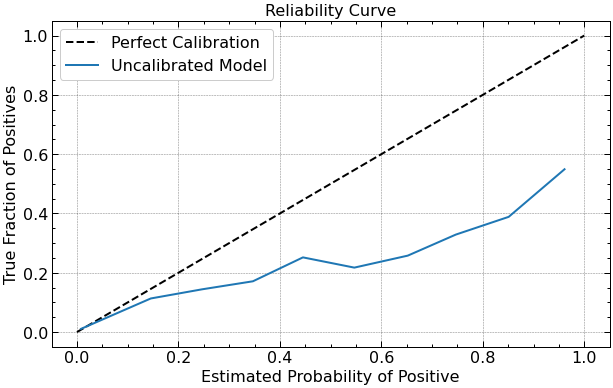

In [260]:
from sklearn.calibration import calibration_curve

probabilities_non = class_balanced.predict_proba(X_test)[:, 1]
probabilities_defect = class_balanced.predict_proba(X_test)[:, 0]

fig, ax = plt.subplots(figsize=(10, 6))

prob_true, prob_pred = calibration_curve(y_test, probabilities_non, n_bins=10)


ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax.plot(prob_pred, prob_true, label='Uncalibrated Model', color=blue)

ax.set(xlabel='Estimated Probability of Positive', ylabel='True Fraction of Positives')
ax.legend(loc='upper left')
plt.title('Reliability Curve')

plt.savefig("/home/saim/Desktop/uncali.png")

In [329]:
from sklearn.metrics import brier_score_loss

print(brier_score_loss(y_test, class_balanced_pred))
print(brier_score_loss(y_test_cal, y_pred_iso))
print(brier_score_loss(y_test_cal, y_pred_sig))

0.14446586964905514
0.05296174413821473
0.05368161250514192


In [335]:
iso_probabilities_non = clf_iso.predict_proba(X_test_cal)[:, 1]
sig_probabilities_non = clf_sig.predict_proba(X_test_cal)[:, 1]

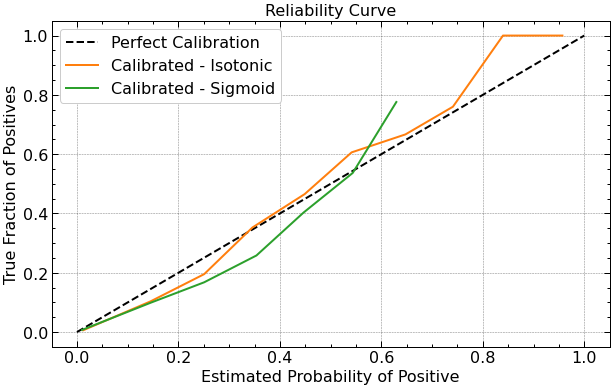

In [338]:
fig, ax = plt.subplots(figsize=(10, 6))

#prob_true, prob_pred = calibration_curve(y_test, probabilities_non, n_bins=10)
prob_true_iso, prob_pred_iso = calibration_curve(y_test_cal, iso_probabilities_non, n_bins=10)
prob_true_sig, prob_pred_sig = calibration_curve(y_test_cal, sig_probabilities_non, n_bins=10)



ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
#ax.plot(prob_pred, prob_true, label='Uncalibrated Model', color=blue)
ax.plot(prob_pred_iso, prob_true_iso, label='Calibrated - Isotonic', color=golden)
ax.plot(prob_pred_sig, prob_true_sig, label='Calibrated - Sigmoid', color=green)


ax.set(xlabel='Estimated Probability of Positive', ylabel='True Fraction of Positives')
ax.legend(loc='upper left')
plt.title('Reliability Curve')

plt.savefig("/home/saim/Desktop/cali.png")

## Threshold

In [344]:
def set_threshold(threshold, model):
    
        predicted_proba = model.predict_proba(X_test_cal)
        thresh_pred = (predicted_proba [:,1] >= threshold).astype('int')
        print(threshold, classification_report(y_test_cal, thresh_pred))

        return thresh_pred

t_pred_x = set_threshold(0.04, clf_sig)


0.04               precision    recall  f1-score   support

       False       1.00      0.82      0.90      9117
        True       0.26      0.95      0.40       607

    accuracy                           0.82      9724
   macro avg       0.63      0.88      0.65      9724
weighted avg       0.95      0.82      0.87      9724



## Evaluation

In [350]:
sig_probabilities = clf_sig.predict_proba(X_test_cal)
    
fpr, tpr, thresh = roc_curve(y_test_cal, sig_probabilities[:, 1])
roc_auc = auc(fpr, tpr)
print('AUC:', round(roc_auc, 3))

AUC: 0.949


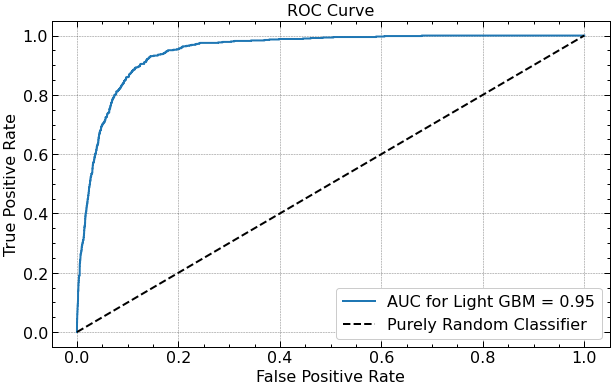

In [369]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fpr, tpr, label = 'AUC for Light GBM = %0.2f' % roc_auc, color=blue)

ax.plot([0, 1], [0, 1],'k--', label='Purely Random Classifier')



ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate")
ax.legend(loc = 'lower right')
    

plt.title('ROC Curve')
plt.savefig("/home/saim/Desktop/model_perf.png")

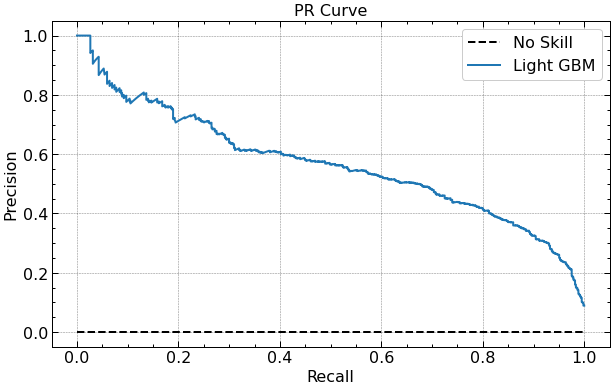

In [368]:
precision, recall, thresholds = precision_recall_curve(y_test_cal.to_numpy().ravel(), sig_probabilities_non)

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot([0, 1], [0, 0],'k--', label='No Skill')
ax.plot(recall, precision, label='Light GBM', color=blue)

ax.set(xlabel = "Recall", ylabel = "Precision")
ax.legend(loc = 'upper right')


plt.title('PR Curve')
plt.savefig("/home/saim/Desktop/PR.png")

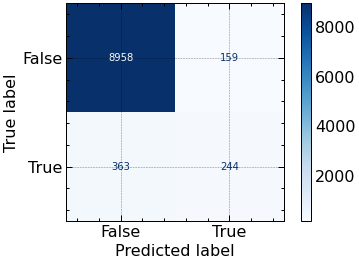

In [355]:
plot_confusion_matrix(clf_sig, X_test_cal, y_test_cal, cmap="Blues")

plt.savefig("/home/saim/Desktop/conf.png")
plt.show()